<a href="https://colab.research.google.com/github/hawkarabdulhaq/hakary/blob/main/akam_week2_cost_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Row        Date  USD (Dollar)  IQD (Iraqi Dinar)
0    1  2024-10-01             1               1320
1    2  2024-10-02             1               1322
2    3  2024-10-03             1               1319
3    4  2024-10-04             1               1321
4    5  2024-10-05             1               1323
Index(['Row', 'Date', 'USD (Dollar)', 'IQD (Iraqi Dinar)'], dtype='object')
        Date  Predicted_IQD
0 2024-10-26    1321.920000
1 2024-10-27    1321.966154
2 2024-10-28    1322.012308
3 2024-10-29    1322.058462
4 2024-10-30    1322.104615
5 2024-10-31    1322.150769
6 2024-11-01    1322.196923
7 2024-11-02    1322.243077
8 2024-11-03    1322.289231
9 2024-11-04    1322.335385


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


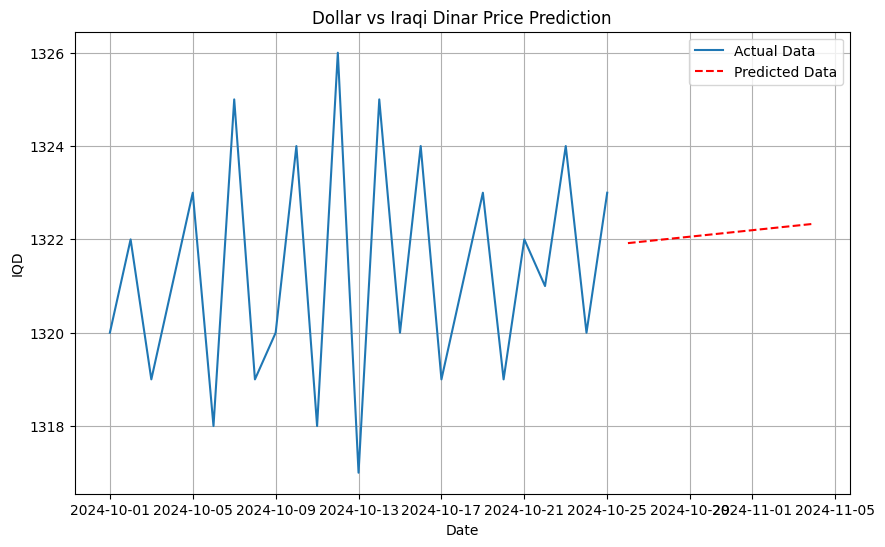

In [ ]:
# Import libraries
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set up Google Sheets access
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name('/content/python-projects-438008-0cc72d2f9367.json', scope)
client = gspread.authorize(creds)

# Load the Google Sheet
sheet = client.open_by_url('https://docs.google.com/spreadsheets/d/1R_7_gAkyCWGQ1Vm1w4m2UmtlsoqPk-iDsM4xvUU1xZo/edit?usp=sharing')

# Access the "Step1" tab
worksheet = sheet.worksheet('Step1')

# Get all data
data = worksheet.get_all_records()

# Convert to DataFrame
df = pd.DataFrame(data)

# Check if data is loaded
print(df.head())  # Print the first few rows of data to verify

# Strip whitespace from columns only if data is present
if not df.empty:
    df.columns = df.columns.astype(str).str.strip()

# Check the data structure and column names
print(df.columns)

# Adjust for actual column names
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Convert date to ordinal for regression
    df['Date_ordinal'] = df['Date'].apply(lambda date: date.toordinal())

    # Set up X (features) and y (target)
    X = df[['Date_ordinal']]
    y = df['IQD (Iraqi Dinar)']  # Use the exact column name you have

    # Train the model
    model = LinearRegression()
    model.fit(X, y)

    # Predict future values (next 10 days)
    last_date = df['Date'].max()
    future_dates = [last_date + timedelta(days=i) for i in range(1, 11)]
    future_dates_ordinal = np.array([date.toordinal() for date in future_dates]).reshape(-1, 1)
    predictions = model.predict(future_dates_ordinal)

    # Display predictions
    future_df = pd.DataFrame({'Date': future_dates, 'Predicted_IQD': predictions})
    print(future_df)

    # Convert the 'Date' column in future_df to string format 'YYYY-MM-DD'
    future_df['Date'] = future_df['Date'].dt.strftime('%Y-%m-%d')

    # Save the predictions to the "Step2" tab
    rows_to_update = [['Date', 'Predicted_IQD']] + future_df.values.tolist()

    # Update Google Sheets with serialized data (string format for dates)
    sheet.worksheet('Step2').update(values=rows_to_update, range_name='A1')

    # Convert Date column in original DataFrame to matplotlib-friendly format
    df['Date'] = pd.to_datetime(df['Date'])

    # Plot the actual data and predictions
    plt.figure(figsize=(10,6))
    plt.plot(df['Date'], df['IQD (Iraqi Dinar)'], label='Actual Data')  # Use correct column name
    plt.plot(pd.to_datetime(future_df['Date']), future_df['Predicted_IQD'], label='Predicted Data', linestyle='--', color='red')
    plt.title('Dollar vs Iraqi Dinar Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('IQD')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("The 'Date' column was not found in the data.")
